# OpenDP Library Exercise

You can work [here in Colab](https://colab.research.google.com/github/opendp/opendp/blob/ppai-notebook/ppai-exercise.ipynb), or download this notebook and edit 
locally.
Use `Shift+Enter` to execute a cell. 
Don't hesitate to look at the linked documentation and examples!

### Install dependencies
`python-dp` is a second, separate DP library that will be used in the last exercise.

In [1]:
%pip install opendp python-dp seaborn

Note: you may need to restart the kernel to use updated packages.


## Exercise 1: DP Sum

### 1.1. Enable "contrib" flag. 

Any constructors that have not completed the proof-writing and vetting process may still be accessed if you opt-in to "contrib".
Please contact us if you are interested in proof-writing. Thank you!

[[Documentation]](https://github.com/opendp/opendp/discussions/304)

In [2]:
# TODO: enable "contrib"
from opendp.mod import enable_features
enable_features("contrib")

# (this assertion should pass)
from opendp.mod import GLOBAL_FEATURES
assert "contrib" in GLOBAL_FEATURES

### 1.2. Data Preprocessing

Write a transformation to cast the data to a vector of floating-point numbers, 
and then clamp the data with bounds of your choosing.

[[Cast Example]](https://docs.opendp.org/en/stable/examples/pums-data-analysis.html#Casting)
[[Clamp Example]](https://docs.opendp.org/en/stable/user/getting-started.html#Transformation-Example:-Clamp)

In [3]:
from opendp.transformations import make_cast_default, make_clamp
import numpy as np
mock_dataset = [str(v) for v in np.random.uniform(low=0., high=1., size=100)]

caster = make_cast_default(str, float)

# set bounds to be used for the rest of our computation:
bounds = (0., 2.)

# construct a clamper!
clamper = make_clamp(bounds)

# chain the caster and clamper together!
bounded_data_trans = caster >> clamper

# print out the first ten values in the parsed data
bounded_data_trans(mock_dataset)[:10]  # this print keeps only ten elements

[0.06684902086786026,
 0.8527914798437328,
 0.07331023513349999,
 0.3037395182295832,
 0.1957530825909216,
 0.9117439967804957,
 0.5529437277308142,
 0.5826976085023571,
 0.8153788763512871,
 0.8392116208522172]

## 1.3. Construct a non-DP Sum Transformation

This sum transformation should be able to chain with the clamp transformation in the previous section.

[[Documentation]](https://docs.opendp.org/en/stable/user/getting-started.html#Transformation-Example:-Sum)

In [4]:
from opendp.transformations import make_bounded_sum

sum_trans = make_bounded_sum(bounds)

# chain the two transformations you've made!
bounded_sum_trans = bounded_data_trans >> sum_trans

## 1.5. Apply a Differentially Private Mechanism
Build a DP Sum measurement by chaining the exact sum with a laplace noise measurement.

[[Documentation]](https://docs.opendp.org/en/stable/user/getting-started.html#The-Laplace-Mechanism)

In [5]:
from opendp.measurements import make_base_laplace

base_laplace = make_base_laplace(scale=1.)

# chain the bounded sum transformation
dp_sum_meas = bounded_sum_trans >> base_laplace

# since you used laplace noise, you should be able to pass in a bound on contributions and get back an ε
print("epsilon:", dp_sum_meas.map(1))

# each release is a random draw from the laplace distribution
print("dp sum 1:", dp_sum_meas(mock_dataset))
print("dp sum 2:", dp_sum_meas(mock_dataset))
print("dp sum 3:", dp_sum_meas(mock_dataset))

epsilon: 2.000000018626452
dp sum 1: 49.992214934474795
dp sum 2: 50.08344963267436
dp sum 3: 50.77737363560543


## Exercise 2: Private Histogram of Poll Results
This code snip downloads a dataset that we'll use for this exercise. Don't forget to comment out the lines indicated by the `TODO`!

In [6]:
# download a dataset
dataset_url = "https://raw.githubusercontent.com/opendp/opendp/ppai-notebook/poll-data.csv"
dataset_path = "poll-data.csv"

# TODO: comment these lines to use the poll data instead
# dataset_url = "https://raw.githubusercontent.com/opendp/dp-test-datasets/master/data/PUMS_california_demographics_1000/data.csv"
# dataset_path = "pums_1000.csv"

# download the data
import os, requests
if not os.path.exists(dataset_path):
    open(dataset_path, "wb").write(requests.get(dataset_url).content)    

dataset_file = open(dataset_path)
next(dataset_file) # discard header
csv_dataset = dataset_file.read()

### 2.1. Load data from a CSV

Construct a transformation that loads data from a CSV and selects a column.

[[Example]](https://docs.opendp.org/en/stable/examples/pums-data-analysis.html#Working-with-CSV-data)

In [7]:
from opendp.transformations import make_split_dataframe, make_select_column

# TODO: replace the column names with col_names = ["Continent"]
col_names = ["Continent"]
df_loader = make_split_dataframe(",", col_names=col_names)

# TODO: replace "age" with the column of interest
column_selector = make_select_column("Continent", TOA=str)

# chain the transformations together!
csv_loader_trans = df_loader >> column_selector

# you should be able to pass the csv dataset in and get a vector of strings
csv_loader_trans(csv_dataset)[:10]

['Africa',
 'South America',
 'North America',
 'North America',
 'North America',
 'North America',
 'South America',
 'North America',
 'Asia',
 'North America']

### 2.2. Compute non-DP Histogram

[[Documentation]](https://docs.opendp.org/en/stable/examples/histograms.html#Private-histogram-via-make_count_by_categories)

In [8]:
from opendp.transformations import make_count_by_categories
categories = ["North America", "South America", "Asia", "Europe", "Africa", "Australia", "Antarctica"]
histogram_trans = make_count_by_categories(categories)

# this assertion should pass:
assert histogram_trans(["North America"] * 2 + ["South America"]) == [2, 1, 0, 0, 0, 0, 0, 0]

The 8th count is the number of rows that are not in the category set.

### 2.3. Apply a Differentially Private Mechanism

In this case, we'll need to make two adjustments to the Laplace mechanism: the noise should be over the integers, and vector-valued.

[[Documentation: Integer]](https://docs.opendp.org/en/stable/user/measurements/additive-noise-mechanisms.html#Support:-Float-vs.%C2%A0Integer)
[[Documentation: Vector]](https://docs.opendp.org/en/stable/user/measurements/additive-noise-mechanisms.html#Domain:-Scalar-vs.%C2%A0Vector)

Choose any valid scale parameter.

In [9]:
from opendp.measurements import make_base_discrete_laplace
base_vector_laplace = make_base_discrete_laplace(scale=1., D="VectorDomain<AllDomain<int>>")

# chain the csv_loader_trans, histogram_trans and vector laplace mechanism:
dp_histogram = csv_loader_trans >> histogram_trans >> base_vector_laplace

print("epsilon:", dp_histogram.map(1))

dp_release = dp_histogram(csv_dataset)
exact_vals = (csv_loader_trans >> histogram_trans)(csv_dataset) 

epsilon: 1.0


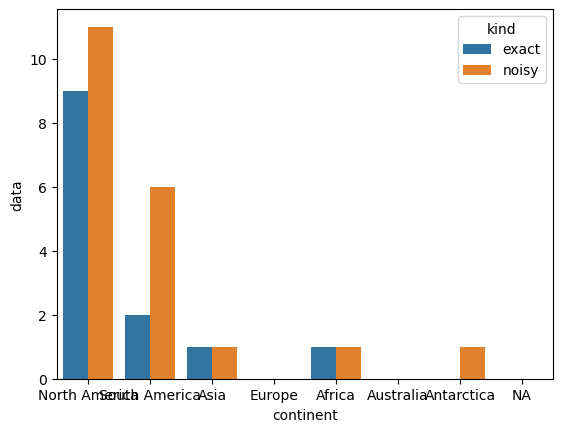

In [10]:
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "continent": categories + ["NA"] + categories + ["NA"],
    "kind": ["exact"] * 8 + ["noisy"] * 8,
    "data": exact_vals + dp_release
})

sns.barplot(x="continent", hue="kind", y="data", data=data);

## Exercise 3: Combinators

### 3.1. Non-Interactive Composition

More than one measurement can be composed together into a single measurement:
[[Documentation]](https://docs.opendp.org/en/stable/user/combinators.html#composition)

You can reuse measurements we've previously constructed as arguments to the basic composition combinator.

In [12]:
from opendp.transformations import make_count
count_meas = csv_loader_trans >> make_count(str) >> make_base_discrete_laplace(1.)

from opendp.combinators import make_basic_composition
basic_composition_meas = make_basic_composition([count_meas, dp_histogram])

# contains the DP histogram and count
print("release:", basic_composition_meas(csv_dataset))
print("epsilon:", basic_composition_meas.map(1))

release: [13, [8, 2, 1, 0, 2, 0, 1, -1]]
epsilon: 2.0


### 3.2. Privacy Measure Casting

You can use a measure-cast combinator to wrap a measurement in a new measurement that gives a privacy guarantee under a different definition of privacy.

[[Documentation]](https://docs.opendp.org/en/stable/user/combinators.html#measure-casting)

The Gaussian measurement gives a guarantee in terms of zero-Concentrated Differential Privacy.
Can you write the equivalent measurement in terms of ε(δ)-DP?

In [13]:
from opendp.measurements import make_base_gaussian
base_zCDP_gaussian = make_base_gaussian(scale=4.)

from opendp.combinators import make_zCDP_to_approxDP
base_approxDP_gaussian = make_zCDP_to_approxDP(base_zCDP_gaussian)

Can you determine $\epsilon$ when $scale = 4.$, $\delta = 1e-7$ and sensitivity $d_{in} = 0.5$?

In [14]:
delta = 1e-7
curve = base_approxDP_gaussian.map(d_in=0.5)
epsilon = curve.epsilon(delta)
epsilon

0.6057285745359845

### 3.3 User-Defined Measurement

The OpenDP Library can incorporate measurements defined by other libraries.
In this exercise, you will write your own measurement that wraps a mechanism in PyDP.

This code snip uses [PyDP](https://github.com/OpenMined/PyDP) to release a DP Count:

In [15]:
# import the Count algorithm from py-DP
from pydp.algorithms.laplacian import Count

x = Count(epsilon=0.6)

x.quick_result([1, 2, 3])

1

Now complete the function and privacy map.

[[Documentation]](https://docs.opendp.org/en/stable/user/combinators.html#user-defined-callbacks)

In [16]:
from opendp.typing import *
from opendp.combinators import make_default_user_measurement
from opendp.mod import enable_features
enable_features("honest-but-curious")


def make_pyDP_count(epsilon):

    from pydp.algorithms.laplacian import Count
    x = Count(epsilon=epsilon)

    def function(data):
        return x.quick_result(data)

    def privacy_map(d_in):
        return d_in * epsilon

    return make_default_user_measurement(
        function,
        privacy_map,
        DI=VectorDomain[AllDomain[i32]],
        DO=AllDomain[i32],
        MI=SymmetricDistance,
        MO=MaxDivergence[f64]
    )

wrapped_meas = make_pyDP_count(epsilon=1.)
wrapped_meas([1, 2, 3])

4

In [ ]:
# If implemented properly, this assertion should pass.
assert wrapped_meas.map(2) == 2.